In [1]:
# General import
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import os
from PIL import Image
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt
%matplotlib inline
# Local import
from Codes.dataprocess import DataGen
from Codes.dataprocess import Export_ep
from Codes.dataprocess import Add_noise
from Codes.algoviolet import violetBD
from Codes.display import Display_ker
from Codes.display import Display_im
from Codes.display import Display_epd
from Codes.myfunc import nablah
from Codes.myfunc import convolve
from Codes.simplex import Simplex

# Minimisation fonction bi-convexe concave

On introduit le probleme d'optimisation biconvex-concave
de déconvolution aveugle d'images 
avec l' a priori de noyau de convolution régulier,

$$
\underset{u \in U ,K \in \Sigma}{\text{min}} \; \underset{v}{\text{sup}} \;
\frac{1}{2} \| g - K * u\|^2 
+ \frac{1}{2} \alpha \| D K \|^2
+ \langle \nabla u , v \rangle
+ \chi_{B,\mu}(v)
\; .
$$

L'espace $\Sigma$ correspond à l'ensemble des simplexes 
(ensemble des noyaux à coefficient positif dont la somme des coefficients vaut 1).
Par extension on notera $\Sigma$ la fonction indicatrice de cet ensemble.
L'espace $U$ correspond à l'hypercube $[0,1]^{N_x \times N_y}$, ou la boule unité pour la norme $L^\infty$.
Sa fonction indicatrice correspond donc à $\chi_{B,1}$.

La fonction à minimiser peut alors se réécrire

$$
\underset{u ,K }{\text{min}} \; \underset{v}{\text{sup}} \;
\frac{1}{2} \| g - K * u\|^2 
+ \chi_{B,1} (u)
+ \frac{1}{2} \alpha \| D K \|^2
+ \Sigma(K)
+\langle \nabla u , v \rangle
+ \chi_{B,\mu}(v)
\; .
$$

On note

$$
L =\frac{1}{2} \| g - K * u\|^2 
+ \frac{1}{2} \alpha \| D K \|^2
+ \langle \nabla u , v \rangle
$$

Pour résoudre ce probleme d'optimisation on se propose de tester l'algorithme suivant,

$$
\left\{
\begin{align}
& \tilde{u}_{k+1} = \text{proj}_{B_1} \; (u_k - \tau \partial_u L(u_k,K_k,v_k) \; )\\
& K_{k+1} = \text{prox}_{\Sigma} \; (K_k - \gamma \partial_K L(\tilde{u}_{k+1},K_k,v_k) \; )\\
& v_{k+1}         = \text{prox}_{B_\mu} \; (v_k + \sigma \partial_v L (u_{k+1},K_{k+1},v_k) \; )\\
& u_{k+1} = \tilde{u}_{k+1} + \theta_u (\tilde{u}_{k+1} - u_k) \quad \text{(relaxation)}
\end{align}
\right.
$$

Question :
est-ce qu'on met une relaxation aussi sur $K$ ?

$$
K_{k+1} = \tilde{K}_{k+1} + \theta_K (\tilde{K}_{k+1} - K_k)  \quad \text{(relaxation aussi ?)}
$$

On écrit alors les dérivées partielles de $L$,

$$
\left\{
\begin{align}
& \partial_u L(u_k,K_k,v_k) \; ) = \text{div} \cdot v_k - \tilde{K} * (g-K*u)\\
& \partial_K L(\tilde{u}_{k+1},K_k,v_k) \; ) = - (g-K*u)*\tilde{u} + \alpha D^TDK \\
& \partial_v L (u_{k+1},K_{k+1},v_k) \; ) =  \nabla u
\end{align}
\right.
$$

On trace les énergies primales et duales au cours de la minimisation

$$
\left\{
\begin{align}
& Ep = \frac{1}{2} \| g - K * u\|^2 
+ \frac{1}{2} \alpha \| D K \|^2
+ \mu. \text{TV} (u) \\
\\
& Ed = - \langle \nabla u ,v \rangle - \chi_{B,\mu}(v)
\end{align}
\right.
$$

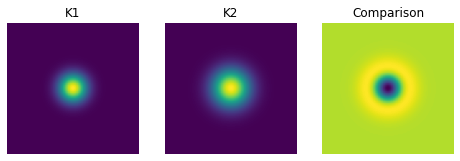

Erreur |K1 - K2|/ |K2| : 0.3500 


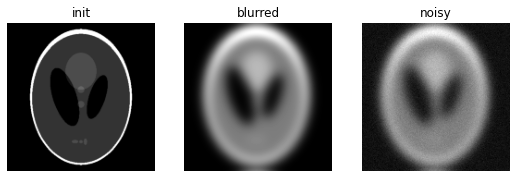

Erreur blurred |x_blurr- x_true|_2 :0.6436
Erreur |x_noisy - x_true|_2 :0.6448


In [2]:
K, K_shift, x_im, x_b, x_o1 = DataGen()

## Initialisation du noyau exacte - bruit std 0.05

Les erreurs initiales sont

$$
\begin{cases}
e_K = 0 \\
e_x = 0.2577
\end{cases}
$$

In [3]:
alpha = 1
mu    = 5
gamma = 1
K_in   = K.copy()
x_in  = x_o1
# K_out,x_out,Ep,Ed = violetBD(K_in,x_in,x_b,\
#                             alpha,mu,gamma,theta=1,\
#                             niter=10000,coeffK=0.1)

In [4]:
#Display_ker(K_out,K_in,mysize=(8,4))

In [5]:
#Display_im(x_out,x_im,mysize=(10,5))

In [6]:
#Display_epd(Ep,Ed)

## Initialisation noyau proche - pas de bruit

In [7]:
alpha     = 1
mu        = 5
gamma     = 1
K_in      = K_shift.copy()
x_in      = x_b
# K_out,x_out,Ep,Ed = violetBD(K_in,x_in,x_b,\
#                             alpha,mu,gamma,theta=1,\
#                             niter=25000,coeffK=5,coeffx=2,\
#                             proj_simplex=False)

iteration 100 %--- gradient K 417.1962 --- gradient x 0.2878
iteration 200 %--- gradient K 230.3736 --- gradient x 0.1509
iteration 300 %--- gradient K 163.1792 --- gradient x 0.0935
iteration 400 %--- gradient K 143.8455 --- gradient x 0.0713
iteration 500 %--- gradient K 133.1163 --- gradient x 0.0586
iteration 600 %--- gradient K 129.5068 --- gradient x 0.0507
iteration 700 %--- gradient K 130.1286 --- gradient x 0.0466
iteration 800 %--- gradient K 132.3969 --- gradient x 0.0451
iteration 900 %--- gradient K 134.8456 --- gradient x 0.0450
iteration 1000 %--- gradient K 137.6563 --- gradient x 0.0456
iteration 1100 %--- gradient K 140.7322 --- gradient x 0.0467
iteration 1200 %--- gradient K 143.7799 --- gradient x 0.0485
iteration 1300 %--- gradient K 146.6257 --- gradient x 0.0505
iteration 1400 %--- gradient K 149.8733 --- gradient x 0.0528
iteration 1500 %--- gradient K 153.2099 --- gradient x 0.0550
iteration 1600 %--- gradient K 156.5380 --- gradient x 0.0571
iteration 1700 %-

iteration 13300 %--- gradient K 186.2292 --- gradient x 0.0764
iteration 13400 %--- gradient K 186.6023 --- gradient x 0.0766
iteration 13500 %--- gradient K 186.9893 --- gradient x 0.0768
iteration 13600 %--- gradient K 187.3874 --- gradient x 0.0770
iteration 13700 %--- gradient K 187.7811 --- gradient x 0.0772
iteration 13800 %--- gradient K 188.1108 --- gradient x 0.0774
iteration 13900 %--- gradient K 188.4355 --- gradient x 0.0776
iteration 14000 %--- gradient K 188.7527 --- gradient x 0.0778
iteration 14100 %--- gradient K 189.0535 --- gradient x 0.0779
iteration 14200 %--- gradient K 189.3419 --- gradient x 0.0781
iteration 14300 %--- gradient K 189.6253 --- gradient x 0.0782
iteration 14400 %--- gradient K 189.9120 --- gradient x 0.0783
iteration 14500 %--- gradient K 190.2469 --- gradient x 0.0785
iteration 14600 %--- gradient K 190.5555 --- gradient x 0.0787
iteration 14700 %--- gradient K 190.8467 --- gradient x 0.0788
iteration 14800 %--- gradient K 191.1027 --- gradient x

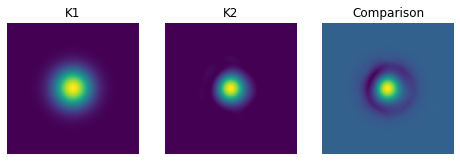

Erreur |K1 - K2|/ |K2| : 0.4890 


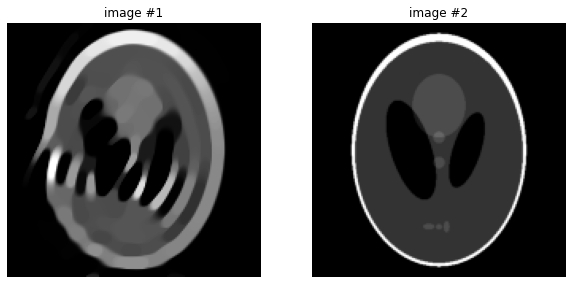

Erreur |im1 - im2|/|im2| :0.6048


In [15]:
# Display_ker(K_out,K_in,mysize=(8,4))
# Display_im(x_out,x_im,mysize=(10,5))

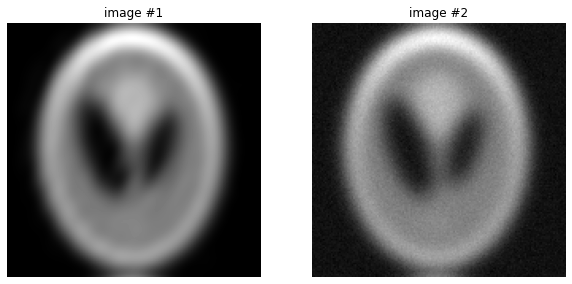

Erreur |im1 - im2|/|im2| :0.0518


In [24]:
# # local parameters and matrix sizes
M,_    = K.shape
M      = M//2 # kernel middle size
Nx, Ny = x_b.shape # image size
# kernel position (for padding)
min_x  = Nx//2+1-M-2
max_x  = Nx//2+M-1
min_y  = Ny//2+1-M-2
max_y  = Ny//2+M-1
# Initialisation
Kk                          = np.zeros((Nx,Ny))
Kk[min_x:max_x,min_y:max_y] = K_out
Display_im(convolve(x_out,Kk),x_o1,mysize=(10,5))

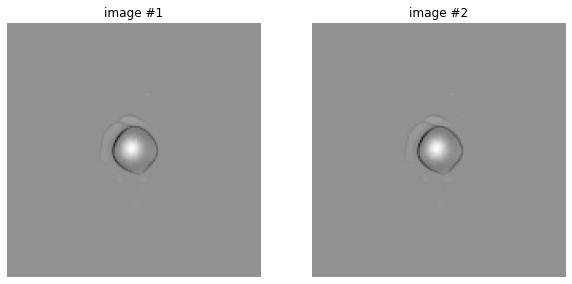

Erreur |im1 - im2|/|im2| :0.0000


In [25]:
# Derivation
d      = -np.ones((3,3))
d[1,1] = 8
d_pad  = np.zeros((Nx,Ny))
d_pad[Nx//2-1:Nx//2+2,Ny//2-1:Ny//2+2] = d
Display_im(convolve(d_pad,Kk),convolve(d_pad,Kk),mysize=(10,5))

In [26]:
np.amax(convolve(d_pad,Kk)-convolve(d_pad,Kk))

0.0

In [14]:
Export_ep(Ep,label='2')

## Initialisation noyau proche - bruit std 0.05
Les erreurs initiales sont

$$
\begin{cases}
e_K=0.2811 \\
e_x=0.2724
\end{cases}
$$

In [18]:
alpha = 1
mu    = 5
gamma = 1
K_in      = K_shift.copy()
x_in      = x_o1
K_out,x_out,Ep,Ed = violetBD(K_in,x_in,x_o1,\
                            alpha,mu,gamma,theta=1,\
                            niter=25000,coeffK=5,coeffx=1,\
                            proj_simplex=False)

iteration 100 %--- gradient K 548.6499 --- gradient x 0.4410
iteration 200 %--- gradient K 301.2601 --- gradient x 0.2178
iteration 300 %--- gradient K 231.6876 --- gradient x 0.1472
iteration 400 %--- gradient K 204.0979 --- gradient x 0.1083
iteration 500 %--- gradient K 188.6977 --- gradient x 0.0879
iteration 600 %--- gradient K 179.6841 --- gradient x 0.0781
iteration 700 %--- gradient K 174.2442 --- gradient x 0.0720
iteration 800 %--- gradient K 171.4773 --- gradient x 0.0680
iteration 900 %--- gradient K 170.1725 --- gradient x 0.0646
iteration 1000 %--- gradient K 169.0980 --- gradient x 0.0625
iteration 1100 %--- gradient K 168.4827 --- gradient x 0.0608
iteration 1200 %--- gradient K 168.2909 --- gradient x 0.0596
iteration 1300 %--- gradient K 168.3408 --- gradient x 0.0587
iteration 1400 %--- gradient K 168.5673 --- gradient x 0.0580
iteration 1500 %--- gradient K 168.7819 --- gradient x 0.0573
iteration 1600 %--- gradient K 169.2385 --- gradient x 0.0569
iteration 1700 %-

iteration 13300 %--- gradient K 172.2552 --- gradient x 0.0541
iteration 13400 %--- gradient K 172.3575 --- gradient x 0.0542
iteration 13500 %--- gradient K 172.4644 --- gradient x 0.0542
iteration 13600 %--- gradient K 172.5609 --- gradient x 0.0543
iteration 13700 %--- gradient K 172.6683 --- gradient x 0.0543
iteration 13800 %--- gradient K 172.7844 --- gradient x 0.0544
iteration 13900 %--- gradient K 172.9003 --- gradient x 0.0544
iteration 14000 %--- gradient K 173.0231 --- gradient x 0.0545
iteration 14100 %--- gradient K 173.1663 --- gradient x 0.0545
iteration 14200 %--- gradient K 173.2954 --- gradient x 0.0546
iteration 14300 %--- gradient K 173.4084 --- gradient x 0.0547
iteration 14400 %--- gradient K 173.5245 --- gradient x 0.0547
iteration 14500 %--- gradient K 173.6353 --- gradient x 0.0548
iteration 14600 %--- gradient K 173.7546 --- gradient x 0.0549
iteration 14700 %--- gradient K 173.8882 --- gradient x 0.0549
iteration 14800 %--- gradient K 174.0308 --- gradient x

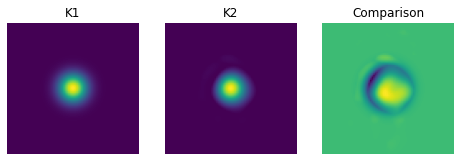

Erreur |K1 - K2|/ |K2| : 0.1424 


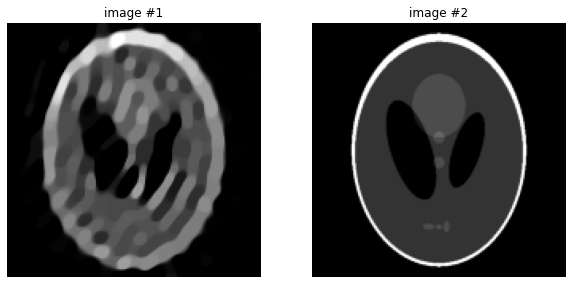

Erreur |im1 - im2|/|im2| :0.5727


In [19]:
Display_ker(K_out,K,mysize=(8,4))
Display_im(x_out,x_im,mysize=(10,5))

In [21]:
Export_ep(Ep,label='2')#,cas='3')

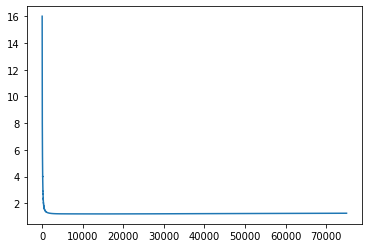

In [22]:
plt.plot(Ep)

### ANNEXES

In [ ]:
Nx,Ny = x_i.shape
# Kernel padding
K_pad = np.zeros(x_i.shape)
K_pad[Nx//2+1-M-2:Nx//2+M-1,Ny//2+1-M-2:Ny//2+M-1] = K
# Derivation padding
d      = -np.ones((3,3))
d[1,1] = 8
d_pad  = np.zeros((Nx,Ny))
d_pad[Nx//2-1:Nx//2+2,Ny//2-1:Ny//2+2] = d
# Parameters
alpha = 1*80**2
mu    = 1
gamma = 1
#
conv1 = convolve(K_pad,x_i)
conv2 = convolve(d_pad,K_pad)
ux,uy = nablah(x_i)
normu = np.abs(ux)+np.abs(uy)
#
Ep_b  = 0.5*gamma*np.linalg.norm(conv1-x_b)**2 \
          + 0.5*alpha*np.linalg.norm(conv2)**2\
          + mu/Nx/Ny*np.sum(normu)
Ep_o1  = 0.5*gamma*np.linalg.norm(conv1-x_o1)**2 \
          + 0.5*alpha*np.linalg.norm(conv2)**2\
          + mu/Nx/Ny*np.sum(normu)
print(" Min functionnal blurred : {:.6f},\
     \n Min functionnal noise   : {:.6f}".format(Ep_b,Ep_o1))